### Parametri dataset

1. disp_min e disp_max
    - Definiscono l’intervallo di disparità in cui l’algoritmo deve cercare la corrispondenza.
    - disp_min = 0; disp_max = 15 -> Significa: $d \in [0, 15]$
    - Riduce il costo computazionale
    - Evita corrispondenze sbagliate

2. disp_scale
    - the scale factor needed to obtain a disparity map coherent with the ground-truth disparity map (specified by the parameter disp_scale)
    - Serve a convertire la disparità stimata nel formato della ground truth.
    - la ground-truth disparity map non è in pixel interi ma in pixel × 16 (disparità sub-pixel);
        - con 16 = valore di disp_scale
    - In pratica, se il tuo algoritmo produce: d = 7.5 pixel
    - devi salvarlo come: 7.5 × 16 = 120 nella disparity_map per confrontarlo con la disparity_map_ground_truth
    - Questo permette precisione sub-pixel della disparity senza usare float (che non possono essere mostrati in una scala di grigi)

3. ignore_border
   - the width of the image border to be ignored when evaluating the experimental results
   - Significa non valutare:
        - primi 18 pixel a sinistra/destra
        - primi 18 pixel in alto/basso
    - Ai bordi non tutte le disparità sono valide
        - i pixel potrebbero non avere corrispondenza
        - molti algoritmi usano finestre che “escono” dall’immagine
    - Penalizzare la bontà dell'algoritmo a causa di questi pixel sarebbe ingiusto.

4. ref
    - immagine da usare come riferimento per calcolare la disparity map
    - le corrispondenze andranno cercate nell'altra immagine

5. groundtruth
   - disparity map che fa da ground truth per valutare la bontà della disparity map che produciamo

In [1]:
def is_int(s):
    try:
        int(s)
        return True
    except ValueError:
        return False

def parse_dataset_config(path):
    config = {}

    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue  # salta righe vuote

            key, value = line.split() # split della linea ad ogni whitespace
            if is_int(value):
                config[key] = int(value)
            else:
                config[key] = value

    return config

# First task: development of a baseline stereo matching algorithm

Students are required to develop an **area-based stereo matching algorithm** based on comparing pixel intensities within windows centered at candidate corresponding points. More precisely, for each point in the reference image, the window centered at that point is compared to all those centered at the points in the other image laying on the same row and within the disparity range. 

The comparison between windows must be carried out according to the **SAD (Sum of Absolute Differences) dissimilarity function**. The window providing the lowest SAD determines the corresponding point in the other image and thus the disparity value for the given point in the reference image (**winner-takes-all approach**).

Then, results must be evaluated quantitatively according to the methodology described in Section 4.1. Based on analysis of the obtained results, students should also comment on the main issues that cause errors when computing disparities by the baseline algorithm.

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from pprint import pprint
import time

path_dataset = "./StereoDataset/sawtooth/"

path_config = path_dataset + "param_in.txt"
config = parse_dataset_config(path_config)
pprint(config)

path_im_left = path_dataset + "imL.ppm"
path_im_right = path_dataset + "imR.ppm"

path_groundtruth = path_dataset + config["groundtruth"]

{'disp_max': 19,
 'disp_min': 0,
 'disp_scale': 8,
 'groundtruth': 'groundtruth.pgm',
 'ignore_border': 0,
 'ref': 'imR.ppm'}


shapes: l=(380, 434, 3); r=(380, 434, 3)


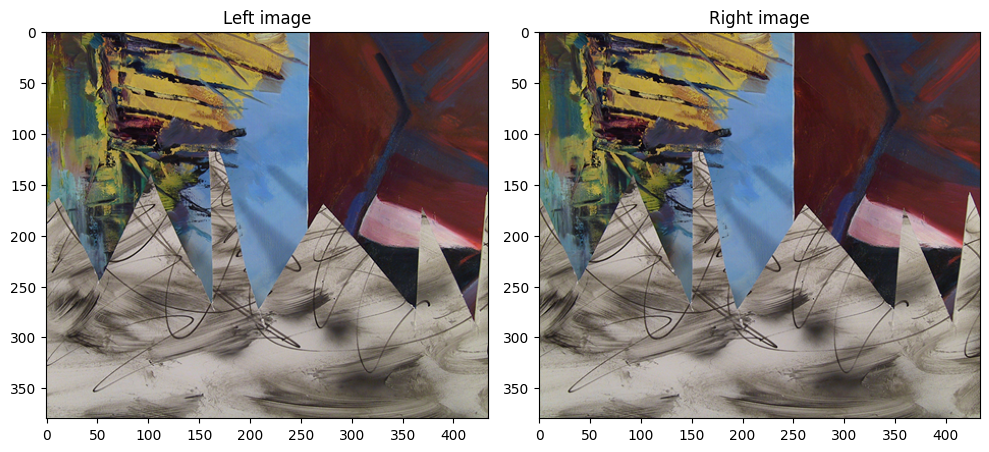

In [3]:
im_l = cv2.imread(path_im_left)
im_r = cv2.imread(path_im_right)

print(f"shapes: l={im_l.shape}; r={im_r.shape}")

plt.figure(figsize=(10,8))

plt.subplot(1, 2, 1)
plt.title("Left image")
plt.imshow(cv2.cvtColor(im_l, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title("Right image")
plt.imshow(cv2.cvtColor(im_r, cv2.COLOR_BGR2RGB))

plt.tight_layout()
plt.show()

In [4]:
# Capiamo dal file di configurazione qual'è l'immagine a cui la disparity map
# fa riferimento, e qual'è quella in cui andiamo a cercare le corrispondenze (target)
im_ref = None
im_target = None

if path_im_left.removeprefix(path_dataset) == config["ref"]:
    im_ref = im_l # riferimento, modifica anche l'originale
    im_target = im_r
else:
    im_ref = im_r
    im_target = im_l

In [5]:
### ATTENZIONE: questo è un parametro molto importante!
### Per adesso lo imposto ad un valore aribtrario; a breve
### discuterò come regolarlo
window_size = 7
window_radius = (window_size-1) // 2

h, w, c = im_ref.shape
print(f"Reference image ha shape {im_ref.shape}")
ignored_border_pixels = config["ignore_border"]
# TODO togli questa semplificazione
ignored_border_pixels = window_radius + config["disp_max"]
print(f"- ignoro {ignored_border_pixels} border pixels")

# costruisco gli indici che dovrò considerare nella reference image
start_row = ignored_border_pixels
end_row = h-ignored_border_pixels
start_col = ignored_border_pixels
end_col = w-ignored_border_pixels
considered_rows = list(range(start_row, end_row))
considered_cols = list(range(start_col, end_col))
print(f"- considero le righe [{start_row}, {end_row}[ e le colonne [{start_col}, {end_col}[")

disparity_range = list(range(config["disp_min"], config["disp_max"]+1))
print(f"\nLe corrispondenze verranno cercate nel disparity-range [{config["disp_min"]}, {config["disp_max"]}]")



Reference image ha shape (380, 434, 3)
- ignoro 22 border pixels
- considero le righe [22, 358[ e le colonne [22, 412[

Le corrispondenze verranno cercate nel disparity-range [0, 19]


In [6]:
def compare_windows(im_ref, im_target, row, col, disparity, window_radius):
    # sad = 0
    # for window_row in range(-window_radius, window_radius+1):
    #     for window_col in range(-window_radius, window_radius+1):
    #         for c in range(channels):
    #             # attenzione a convertire gli interi unsigned in interi con segno, altrimenti la differenza va in overflow
    #             sad += abs(int(im_ref[row+window_row, col+window_col, c]) - int(im_target[row+window_row, col+window_col+disparity, c]))
    # return sad

    window_ref = im_ref[row-window_radius : row+window_radius+1, col-window_radius : col+window_radius+1]
    window_target = im_target[row-window_radius : row+window_radius+1, col-window_radius+disparity : col+window_radius+disparity+1]
    
    # attenzione a convertire i numpy.uint8 in interi con segno, altrimenti la differenza può andare in underflow
    sad = np.sum(np.abs(window_ref.astype(int) - window_target.astype(int)))
    
    return sad
    

def find_correspondence(im_ref, im_target, row, col, window_radius, disparity_range):
    """
    docstring
    """
        
    best_disparity = None
    best_sad = None
    
    for d in disparity_range:
        sad = compare_windows(im_ref, im_target, row, col, d, window_radius)
        
        if best_sad == None:
            best_disparity = d
            best_sad = sad

        if sad < best_sad:
            best_disparity = d
            best_sad = sad

    return best_disparity, best_sad

In [7]:
disparity_map = np.zeros((h, w))

start = time.perf_counter()
for row in considered_rows:
    for col in considered_cols:
        disp, _ = find_correspondence(im_ref, im_target, row, col, window_radius, disparity_range)
        disparity_map[row, col] = disp*config["disp_scale"]
t_exec=time.perf_counter()-start
print(f"Tempo impiegato a calcolare la disparity map: {t_exec:.2f} s")

Tempo impiegato a calcolare la disparity map: 8.59 s


Avrei potuto decidere anche di non calcolare la disparity sui bordi della ref image dato che non hanno abbastanza pixel per la finestra completa

- calcoli la disparity solo dove la finestra è completa
- ignore_border = window_radius + disp_max

Ho deciso di seguire quanto riportato nel file di config usando una finestra parziale ai bordi

In [8]:
gt_disparity_map = cv2.imread(path_groundtruth, cv2.IMREAD_GRAYSCALE)

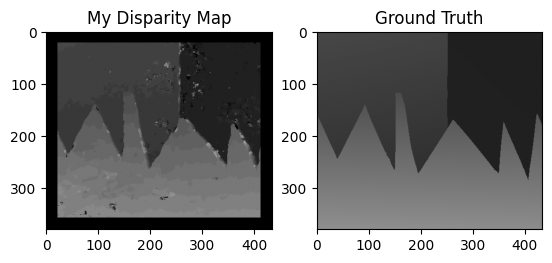

<Figure size 640x480 with 0 Axes>

In [9]:
plt.subplot(1, 2, 1)
plt.title("My Disparity Map")
plt.imshow(disparity_map, cmap="gray", vmin=0, vmax=255)
plt.subplot(1, 2, 2)
plt.title("Ground Truth")
plt.imshow(gt_disparity_map, cmap="gray", vmin=0, vmax=255)
plt.show()

plt.tight_layout()
plt.show()

# Evaluation of the results provided by the baseline algorithm

Results should be evaluated quantitatively by comparison to the available groundtruth. More precisely, students should rely on the Error function, E:

$$
E = \frac{\sum_{p \in \text{Area}} S(p, p_{gt})}{N_{\text{Area}}}
$$

where function $S(p, p_{gt})$ is 1/0 depending on the absolute difference between the
disparity, $p$, computed at a pixel of the reference image and the associated groundtruth disparity, $p_{gt}$, being greater/less than 1

$$
S(p, p_{gt}) =
\begin{cases}
1, & \lvert p - p_{gt} \rvert > 1 \\
0, & \text{otherwise}
\end{cases}
$$

$Area$ and $N_{Area}$ represent, respectively:
- the area of the reference image within which the matching process can be executed
- the number of pixels in that area

As illustrated below, $Area$ is the central region of the reference image whose size depends on that of the window used for the matching process, which is assumed here
squared and having size $(2K+1) \times (2K+1)$ pixel, so that $N_{Area} = (W-2K)(H-2K)$

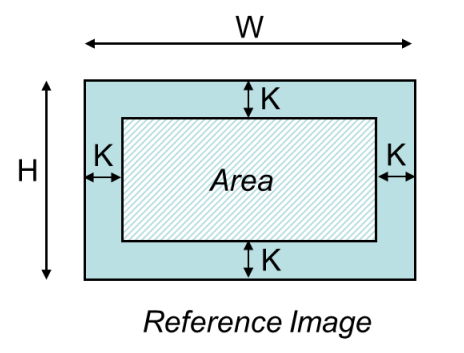


In [10]:
def S(disparity_map, ground_truth, tolleranza):
    # di nuovo, attenzione ad underflow dovuti a uint
    diff_map = np.abs(disparity_map.astype(int) - ground_truth.astype(int))
    error_mask = diff_map>tolleranza
    # converto i boolean risultanti dall'operazione logica in interi e sommo
    error_sum = np.sum(error_mask.astype(int))
    # gia che ci sono costruisco anche una mappa per visulizzare dove sto
    # commettendo degli errori
    error_map = np.zeros(diff_map.shape)
    error_map[error_mask] = diff_map[error_mask]

    return error_sum, error_map

def compare_to_gt(disparity_map, ground_truth, tolleranza, n_area):
    error_sum, error_map = S(disparity_map, ground_truth, tolleranza)
    error_percentage = error_sum/n_area 
    
    return error_percentage, error_map

In [11]:
area_disparity_map = disparity_map[start_row:end_row, start_col:end_col]
area_ground_truth = gt_disparity_map[start_row:end_row, start_col:end_col]

tolleranza = 1
# Ho interpretato la tolleranza in pixel, e non in pixel/disp_scale.
# Per questo motivo scalo la tolleranza per il fattore con cui scalo
# la disparità.
tolleranza *= config["disp_scale"]

n_area = len(considered_rows) * len(considered_cols)
error_percentage, _ = compare_to_gt(area_disparity_map, area_ground_truth, tolleranza, n_area)
print(f"La disparity map calcolata ha un errore pari al {error_percentage*100:.2f}% rispetto alla ground truth")

La disparity map calcolata ha un errore pari al 8.85% rispetto alla ground truth


## Proviamo con tutto il dataset

Nota: Le immagini dentro la cartella map/ sono grayscale mentre le altre sono a colori. Le immagini grayscale andrebbero caricate in maniera appropriata, caricandole normalmente però OpenCV copia automaticamente le intensità sui 3 canali.

Per gestire tutte le scene in maniera uniforme considererò anche le immagini dentro a map/ come a colori, questo non cambia i risultati (faccio solo qualche calcolo in più)

In [32]:
def show_stereo_pair(left_image, right_image, name=None):    
    plt.subplot(1, 2, 1)
    plt.title(f"Left image {name}")
    plt.imshow(cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB))
    
    plt.subplot(1, 2, 2)
    plt.title(f"Right image {name}")
    plt.imshow(cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB))
    
    plt.tight_layout()
    plt.show()

def show_disparity_map_and_groundtruth(disparity_map, groundtruth, error_map):
    plt.figure(figsize=(10,8))
    
    plt.subplot(1, 3, 1)
    plt.title("My Disparity Map")
    plt.imshow(disparity_map, cmap="gray", vmin=0, vmax=255)
    
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(groundtruth, cmap="gray", vmin=0, vmax=255)

    plt.subplot(1, 3, 3)
    plt.title("Error Map")
    plt.imshow(error_map, cmap="gray", vmin=0, vmax=255)

    plt.tight_layout()
    plt.show()

def compute_and_evaluate_disparity(path_dataset, window_radius, show_stereo_img=True, show_disparity_maps=True):
    ### Leggiamo la configurazione e costruiamo path vari 
    # Scelgo il penultimo dato che ./StereoDataset/map/
    # produce ['.', 'StereoDataset', 'map', '']
    scene = path_dataset.split("/")[-2]
    path_config = path_dataset + "param_in.txt"
    config = parse_dataset_config(path_config)
    print(f"Parameters for scene: \"{scene}\"")
    pprint(config)
    path_groundtruth = path_dataset + config["groundtruth"]
    path_im_left = path_dataset + "imL.ppm"
    path_im_right = path_dataset + "imR.ppm"
    

    ### Carichiamo le immagini
    im_l = cv2.imread(path_im_left)
    im_r = cv2.imread(path_im_right)
    if show_stereo_img:
        show_stereo_pair(im_l, im_r, name=scene)

    ### Capiamo dal file di configurazione qual'è l'immagine a cui la disparity map
    ### fa riferimento, e qual'è quella in cui andiamo a cercare le corrispondenze (target)
    im_ref = None
    im_target = None
    if path_im_left.removeprefix(path_dataset) == config["ref"]:
        im_ref = im_l
        im_target = im_r
    else:
        im_ref = im_r
        im_target = im_l

    ### Costruiamo gli indici da considerare nella reference image
    h, w, c = im_ref.shape
    print(f"Reference image ha shape {im_ref.shape}")
    ignored_border_pixels = config["ignore_border"]
    # TODO togli questa semplificazione
    ignored_border_pixels = window_radius + config["disp_max"]
    print(f"- ignoro {ignored_border_pixels} border pixels")
    start_row = ignored_border_pixels
    end_row = h-ignored_border_pixels
    start_col = ignored_border_pixels
    end_col = w-ignored_border_pixels
    considered_rows = list(range(start_row, end_row))
    considered_cols = list(range(start_col, end_col))
    print(f"- considero le righe [{start_row}, {end_row}[ e le colonne [{start_col}, {end_col}[\n")
    
    disparity_range = list(range(config["disp_min"], config["disp_max"]+1))
    print(f"Le corrispondenze verranno cercate nel disparity-range [{config["disp_min"]}, {config["disp_max"]}]\n")

    ### Calcolo la disparity map
    start = time.perf_counter()
    disparity_map = np.zeros((h, w))
    for row in considered_rows:
        for col in considered_cols:
            disp, _ = find_correspondence(im_ref, im_target, row, col, window_radius, disparity_range)
            disparity_map[row, col] = disp*config["disp_scale"]
    t_exec=time.perf_counter()-start
    print(f"Tempo impiegato a calcolare la disparity map di {scene}: {t_exec:.2f} s")
    
    ### Valuto la disparity map
    gt_disparity_map = cv2.imread(path_groundtruth, cv2.IMREAD_GRAYSCALE)
    area_disparity_map = disparity_map[start_row:end_row, start_col:end_col]
    area_ground_truth = gt_disparity_map[start_row:end_row, start_col:end_col]
    tolleranza = 1
    # Ho interpretato la tolleranza in pixel, e non in pixel/disp_scale.
    # Per questo motivo scalo la tolleranza per il fattore con cui scalo
    # la disparità.
    tolleranza *= config["disp_scale"]
    n_area = len(considered_rows) * len(considered_cols)
    error_percentage, error_map = compare_to_gt(area_disparity_map, area_ground_truth, tolleranza, n_area)
    print(f"La disparity map calcolata ha un errore pari al {error_percentage*100:.2f}% rispetto alla ground truth\n\n")
    if show_disparity_maps:
        show_disparity_map_and_groundtruth(disparity_map, gt_disparity_map, error_map)

    return {
        "groundtruth": gt_disparity_map,
        "disparity_map": disparity_map,
        "error_map": error_map,
    }

Parameters for scene "map"
{'disp_max': 29,
 'disp_min': 0,
 'disp_scale': 8,
 'groundtruth': 'groundtruth.pgm',
 'ignore_border': 0,
 'ref': 'imR.ppm'}


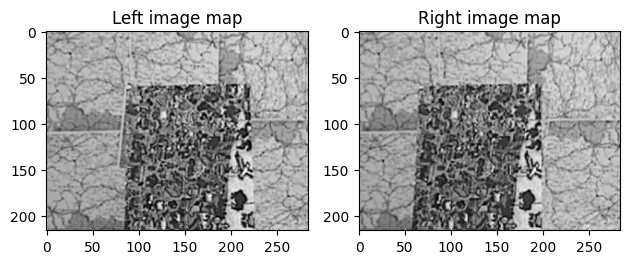

Reference image ha shape (216, 284, 3)
- ignoro 32 border pixels
- considero le righe [32, 184[ e le colonne [32, 252[

Le corrispondenze verranno cercate nel disparity-range [0, 29]

Tempo impiegato a calcolare la disparity map di map: 3.27 s
La disparity map calcolata ha un errore pari al 9.97% rispetto alla ground truth




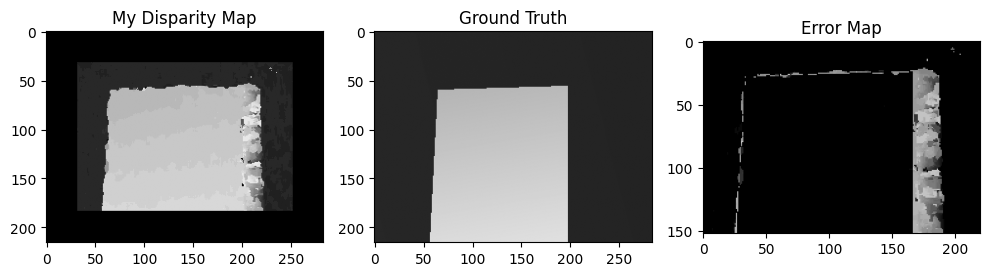

Parameters for scene "sawtooth"
{'disp_max': 19,
 'disp_min': 0,
 'disp_scale': 8,
 'groundtruth': 'groundtruth.pgm',
 'ignore_border': 0,
 'ref': 'imR.ppm'}


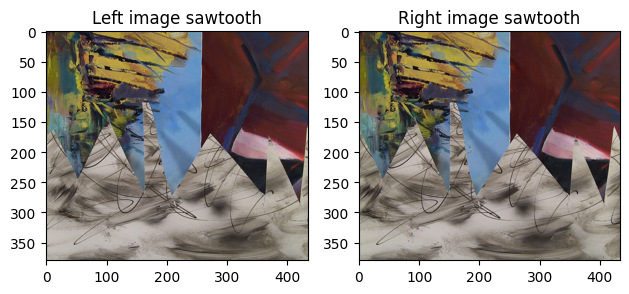

Reference image ha shape (380, 434, 3)
- ignoro 22 border pixels
- considero le righe [22, 358[ e le colonne [22, 412[

Le corrispondenze verranno cercate nel disparity-range [0, 19]

Tempo impiegato a calcolare la disparity map di sawtooth: 8.51 s
La disparity map calcolata ha un errore pari al 8.85% rispetto alla ground truth




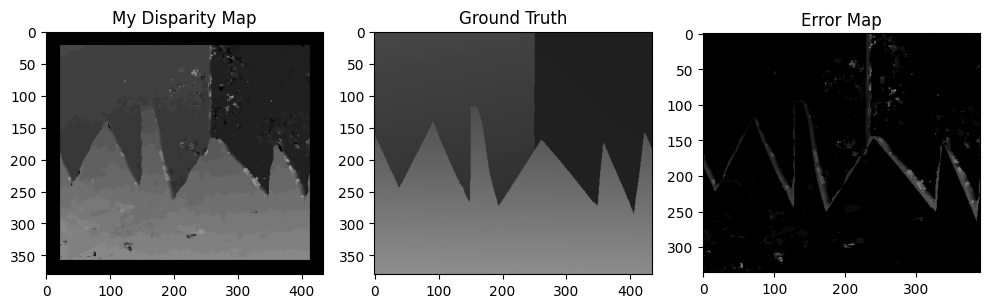

Parameters for scene "tsukuba"
{'disp_max': 15,
 'disp_min': 0,
 'disp_scale': 16,
 'groundtruth': 'groundtruth.pgm',
 'ignore_border': 18,
 'ref': 'imR.ppm'}


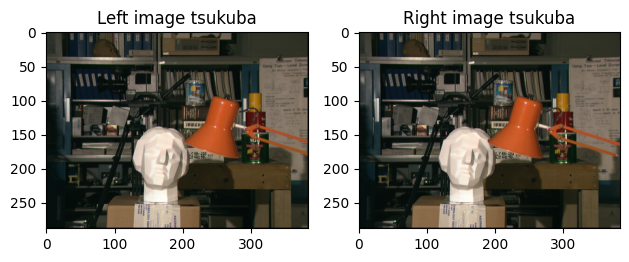

Reference image ha shape (288, 384, 3)
- ignoro 18 border pixels
- considero le righe [18, 270[ e le colonne [18, 366[

Le corrispondenze verranno cercate nel disparity-range [0, 15]

Tempo impiegato a calcolare la disparity map di tsukuba: 4.40 s
La disparity map calcolata ha un errore pari al 11.34% rispetto alla ground truth




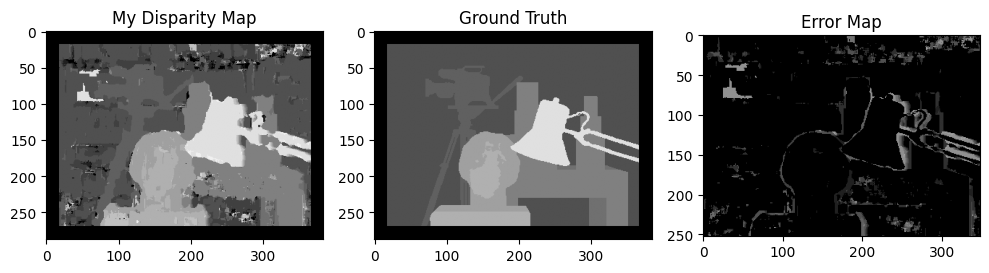

Parameters for scene "venus"
{'disp_max': 19,
 'disp_min': 0,
 'disp_scale': 8,
 'groundtruth': 'groundtruth.pgm',
 'ignore_border': 0,
 'ref': 'imR.ppm'}


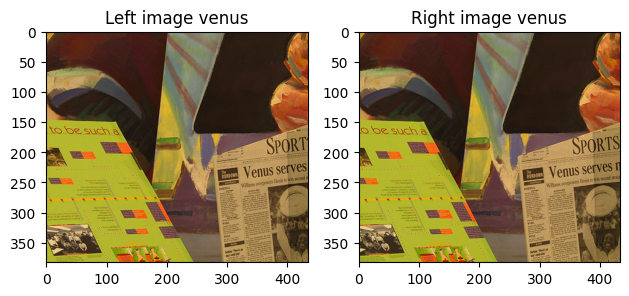

Reference image ha shape (383, 434, 3)
- ignoro 22 border pixels
- considero le righe [22, 361[ e le colonne [22, 412[

Le corrispondenze verranno cercate nel disparity-range [0, 19]

Tempo impiegato a calcolare la disparity map di venus: 8.56 s
La disparity map calcolata ha un errore pari al 17.72% rispetto alla ground truth




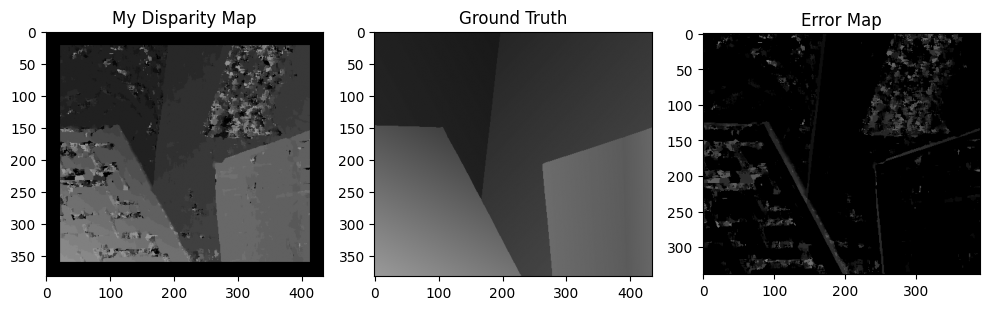

In [33]:
base_path = "./StereoDataset/"
scenes = ["map/", "sawtooth/", "tsukuba/", "venus/"]

### ATTENZIONE: questo è un parametro molto importante!
### Per adesso lo imposto ad un valore aribtrario; a breve
### discuterò di come regolarlo
window_size = 7
window_radius = (window_size-1) // 2

results_basic_sad = {}

for scene in scenes:
    path_dataset = base_path + scene
    res = compute_and_evaluate_disparity(path_dataset, window_radius)
    results_basic_sad[scene] = res

regioni uniformi

bordi irregolari

occlusioni

le mie disparità sono a gradini nel ground truth sono smooth -> disparità subpixel

## Osservazioni e spunti di miglioramento

L'algoritmo basilare ha una percentuale di errore che varia dal 9% al 18%. In particolare, osservando le disparity-map prodotte si può notare che ci sono tre principali categorie di errori:

1. errori nelle regioni uniformi
2. errori vicino ai bordi degli oggetti (depth discontinuities)
3. errori dovuti ad occlusioni

In seguito, verranno descritte le cause di questi errori.

### Errori nelle regioni uniformi

L'idea di base dell'algoritmo a finestra scorrevole implementato è che: quando nell'immagine target si trova la disparità giusta del match, la SAD tra le due finestre ha **un minimo netto rispetto alle altre disparità**. Il problema è che questo non è sempre vero.

Nel caso delle regioni uniformi, se la finestra non è abbastanza grande da catturare dei dettagli caratteristici della regione, **potrebbero esserci diversi valori di disparità che producono una finestra target simile alla finestra nell'immagine di riferimento**.

In questa situazione, diventa ambiguo capire qual'è la disparità giusta, dato che non esiste un minimo netto tra le SAD. Di conseguenza, **a causa del rumore** presente nelle immagini, l'algoritmo sceglie, di fatto, casualmente una tra le disparità possibili. Questo effetto è evidente, ad esempio, nella disparity map di _"Venus"_; in cui si può notare come la regione nera uniforme compaia sostanzialmente come rumore.

Il fattore principale che causa errori dovuti a regioni uniformi è quindi: **l'assenza di dettagli nelle finestre**. Infatti, scene ricche di dettagli come _"map"_ non hanno errori di questo tipo (in _map_ ci sono solo errori sui bordi e di occlusione). Fortunatamente, aumentare il numero di dettagli presenti nelle finestre è semplice, basta **aumentarne la dimensione**. Vista in un'altra maniera, con finestre più grandi è più difficile che il loro contenuto sia totalmente uniforme. 

In seguito, viene mostrato cosa succede alla disparity map della scena _"Venus"_ al crescere della dimensione della finestra. 

Parameters for scene "venus"
{'disp_max': 19,
 'disp_min': 0,
 'disp_scale': 8,
 'groundtruth': 'groundtruth.pgm',
 'ignore_border': 0,
 'ref': 'imR.ppm'}
Reference image ha shape (383, 434, 3)
- ignoro 21 border pixels
- considero le righe [21, 362[ e le colonne [21, 413[

Le corrispondenze verranno cercate nel disparity-range [0, 19]

Tempo impiegato a calcolare la disparity map di venus: 8.19 s
La disparity map calcolata ha un errore pari al 23.84% rispetto alla ground truth




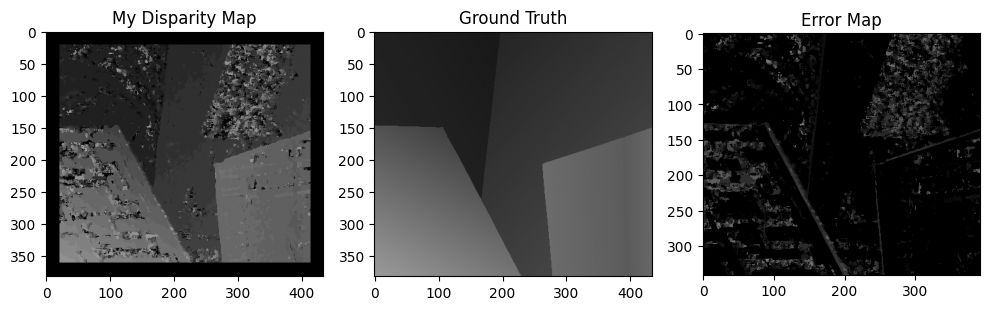

Parameters for scene "venus"
{'disp_max': 19,
 'disp_min': 0,
 'disp_scale': 8,
 'groundtruth': 'groundtruth.pgm',
 'ignore_border': 0,
 'ref': 'imR.ppm'}
Reference image ha shape (383, 434, 3)
- ignoro 23 border pixels
- considero le righe [23, 360[ e le colonne [23, 411[

Le corrispondenze verranno cercate nel disparity-range [0, 19]

Tempo impiegato a calcolare la disparity map di venus: 8.78 s
La disparity map calcolata ha un errore pari al 13.73% rispetto alla ground truth




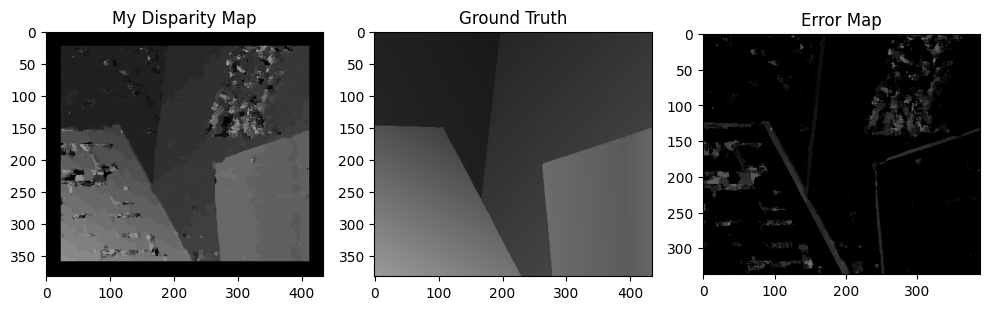

Parameters for scene "venus"
{'disp_max': 19,
 'disp_min': 0,
 'disp_scale': 8,
 'groundtruth': 'groundtruth.pgm',
 'ignore_border': 0,
 'ref': 'imR.ppm'}
Reference image ha shape (383, 434, 3)
- ignoro 25 border pixels
- considero le righe [25, 358[ e le colonne [25, 409[

Le corrispondenze verranno cercate nel disparity-range [0, 19]

Tempo impiegato a calcolare la disparity map di venus: 9.46 s
La disparity map calcolata ha un errore pari al 9.69% rispetto alla ground truth




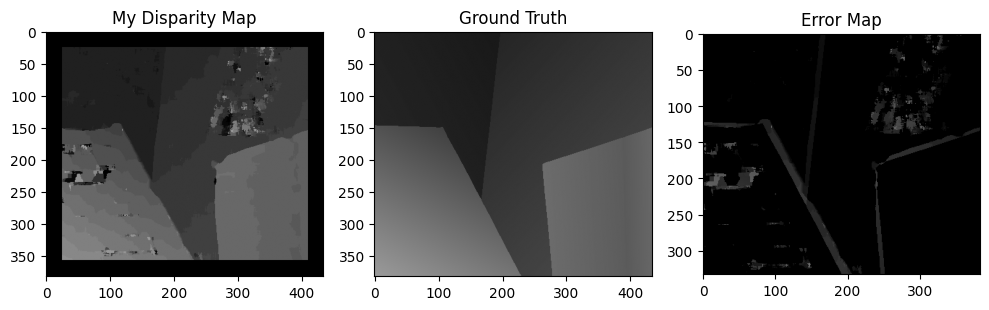

Parameters for scene "venus"
{'disp_max': 19,
 'disp_min': 0,
 'disp_scale': 8,
 'groundtruth': 'groundtruth.pgm',
 'ignore_border': 0,
 'ref': 'imR.ppm'}
Reference image ha shape (383, 434, 3)
- ignoro 27 border pixels
- considero le righe [27, 356[ e le colonne [27, 407[

Le corrispondenze verranno cercate nel disparity-range [0, 19]

Tempo impiegato a calcolare la disparity map di venus: 9.85 s
La disparity map calcolata ha un errore pari al 8.13% rispetto alla ground truth




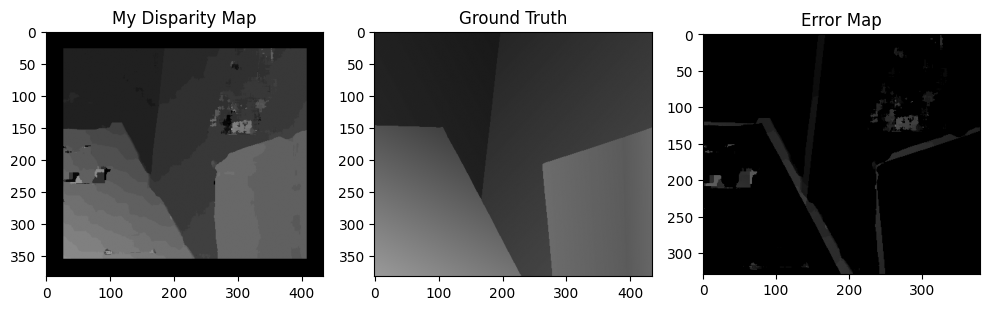

In [35]:
path_dataset = base_path + "venus/"

for w in [5, 9, 13, 17]:
    r = (w-1) // 2
    compute_and_evaluate_disparity(path_dataset, window_radius=r, show_stereo_img=False)

Si nota chiaramente come al crescere della dimensione della finestra, gli errori dovuti alle ambiguità delle regioni uniformi dimuniscano. Siccome, in _"Venus"_, questa categoria di errori era la maggioranza, si ha che anche l'error rate generale diminuisce al crescere della dimensione della finestra (passiamo da ). In conclusione, _"Venus"_, e più in generale scene con molte regioni uniformi, **beneficiano di una dimensione della finestra alta**.  

Tuttavia, va notato anche che: con una finestra più grande, le disparità ai bordi degli oggetti diventano più irregolari. Questo effetto è spiegato dalla prossima categoria di errori.

### Errori vicino ai bordi degli oggetti

I bordi degli oggetti di una scena rappresentano dei punti di **discontinuità della profondità**, e, di conseguenza, della disparità. Questi punti sono problematici per l'algoritmo basilare implementato; quest'ultimo **assume implicitamente che all'interno delle finestre tutti i punti abbiano la stessa disparità**.

Il problema nasce dal fatto che, per definizione di disparità, oggetti con disparità (profondità) diverse subiscono uno spostamento diverso passando da immagine destra a immagine sinistra (o viceversa). Ma allora, se una finestra contiene oggetti con disparità diverse, questo significa che **è impossibile trovare una finestra che sia un match perfetto nell'altra immagine**, dato che la disparità appropriata per un oggetto è sbagliata per gli altri oggetti nella finestra.

L'algoritmo implementato non si preoccupa delle discontinuità di profondità, semplicemente sceglie la disparità che minimizza la SAD; disparità scelte in questa maniera però sono facilmente errate.

Per capire perchè, si consideri una scena simile a _"map"_, in cui è presente uno sfondo lontano è un oggetto (foreground) vicino. Si consideri poi un punto dello sfondo vicino ad un bordo, di cui si vuole calcolare la disparità. Siccome il punto in considerazione appartiene allo sfondo, la disparità corretta dovrebbe essere bassa. Tuttavia, siccome il punto è vicino ad un bordo, la sua finestra nell'immagine di riferimento conterrà parte del foreground, siamo quindi nella situazione in cui non esiste una singola disparità che permetta di trovare un match sia per background che foreground.  

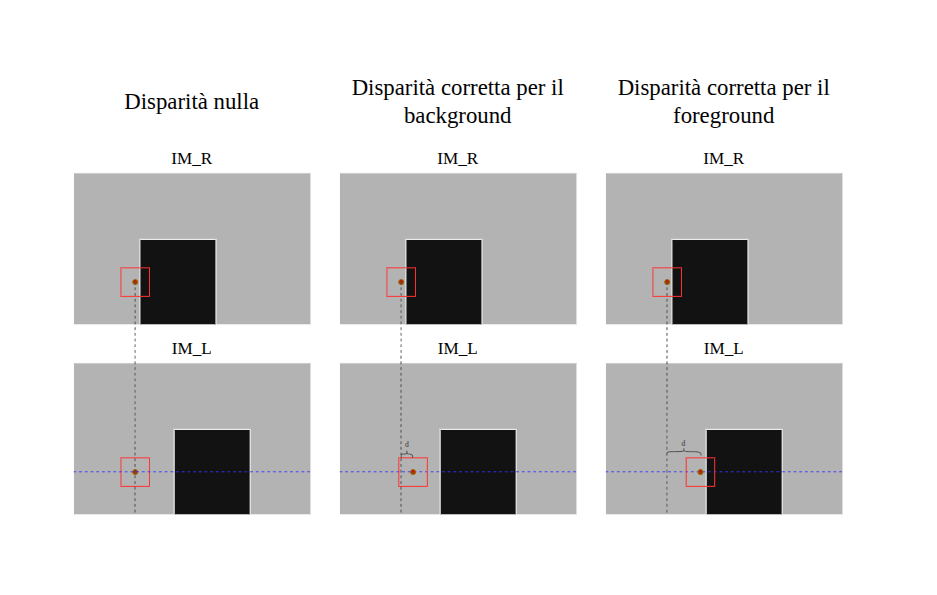

In questa situazione, **l'algoritmo sceglierà la disparità più alta dato che permette di trovare dei match migliori per i pixel di foreground**. Il motivo di questa scelta è dovuto al fatto che i pixel di foreground sono più costosi da sbagliare rispetto ai pixel di background. Si considerino i due casi:

- se nell'immagine target si scegliesse la disparità corretta per i pixel di background, la finestra risultante potrebbe non contenere alcun pixel di foreground (il foreground si sposta "più velocemente" del background). La SAD risultante sarebbe quindi alta.
- se invece si scegliesse la disparità corretta per i pixel di foreground, la finestra risultante conterrà comunque i pixel di background, seppur sbagliati (disparità errata). Nonostante i pixel di background siano sbagliati, la SAD risultante sarà comunque bassa dato che la differenza tra pixel di background diversi è moderata (appartengono allo stesso oggetto).

Il risultato finale è il cosiddetto **_"foreground flattening effect"_**, in cui viene assegnata erroneamente una disparità alta ai pixel di background vicino ai bordi (come se il foreground si espandesse) dato che sbagliare i pixel di foreground produce dei SAD maggiori.

Anche in questo caso la dimensione della finestra è il parametro fondamentale che determina la frequenza con cui errori di questo tipo si verificano. Infatti, **finestre più piccole è più difficile che contengano discontinuità di profondità**. 

In seguito, viene mostrato cosa succede alla disparity map della scena _"Sawtooth"_ al diminuire della dimensione della finestra. 

Parameters for scene "sawtooth"
{'disp_max': 19,
 'disp_min': 0,
 'disp_scale': 8,
 'groundtruth': 'groundtruth.pgm',
 'ignore_border': 0,
 'ref': 'imR.ppm'}
Reference image ha shape (380, 434, 3)
- ignoro 27 border pixels
- considero le righe [27, 353[ e le colonne [27, 407[

Le corrispondenze verranno cercate nel disparity-range [0, 19]

Tempo impiegato a calcolare la disparity map di sawtooth: 9.83 s
La disparity map calcolata ha un errore pari al 8.50% rispetto alla ground truth




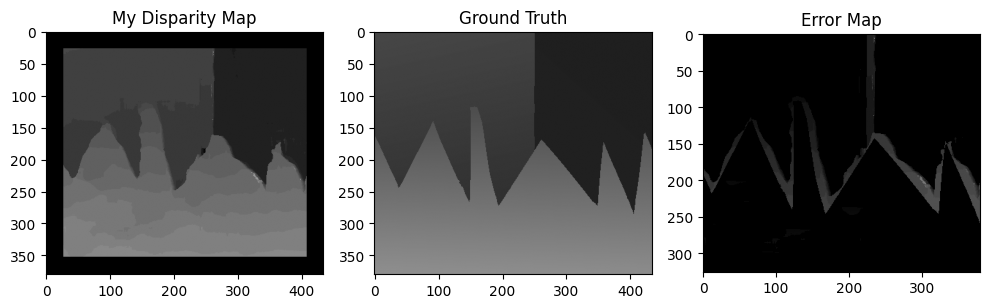

Parameters for scene "sawtooth"
{'disp_max': 19,
 'disp_min': 0,
 'disp_scale': 8,
 'groundtruth': 'groundtruth.pgm',
 'ignore_border': 0,
 'ref': 'imR.ppm'}
Reference image ha shape (380, 434, 3)
- ignoro 25 border pixels
- considero le righe [25, 355[ e le colonne [25, 409[

Le corrispondenze verranno cercate nel disparity-range [0, 19]

Tempo impiegato a calcolare la disparity map di sawtooth: 9.33 s
La disparity map calcolata ha un errore pari al 7.97% rispetto alla ground truth




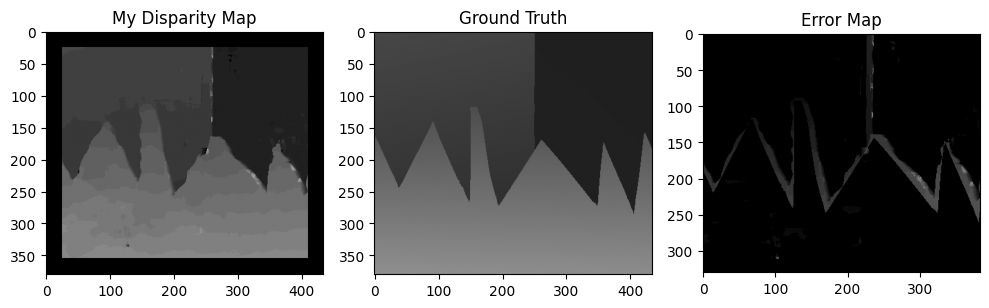

Parameters for scene "sawtooth"
{'disp_max': 19,
 'disp_min': 0,
 'disp_scale': 8,
 'groundtruth': 'groundtruth.pgm',
 'ignore_border': 0,
 'ref': 'imR.ppm'}
Reference image ha shape (380, 434, 3)
- ignoro 23 border pixels
- considero le righe [23, 357[ e le colonne [23, 411[

Le corrispondenze verranno cercate nel disparity-range [0, 19]

Tempo impiegato a calcolare la disparity map di sawtooth: 8.68 s
La disparity map calcolata ha un errore pari al 7.88% rispetto alla ground truth




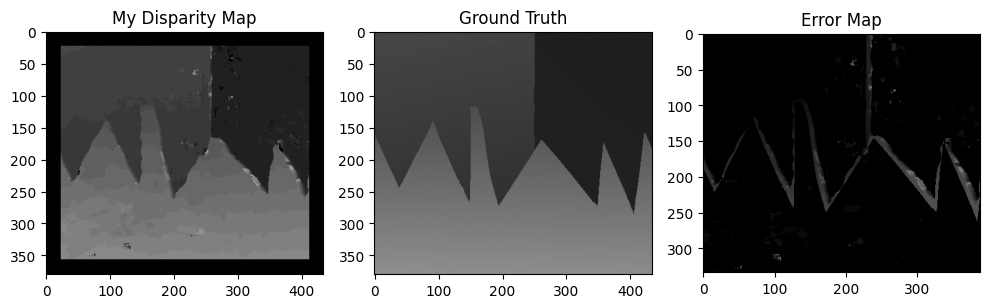

Parameters for scene "sawtooth"
{'disp_max': 19,
 'disp_min': 0,
 'disp_scale': 8,
 'groundtruth': 'groundtruth.pgm',
 'ignore_border': 0,
 'ref': 'imR.ppm'}
Reference image ha shape (380, 434, 3)
- ignoro 21 border pixels
- considero le righe [21, 359[ e le colonne [21, 413[

Le corrispondenze verranno cercate nel disparity-range [0, 19]

Tempo impiegato a calcolare la disparity map di sawtooth: 8.06 s
La disparity map calcolata ha un errore pari al 11.72% rispetto alla ground truth




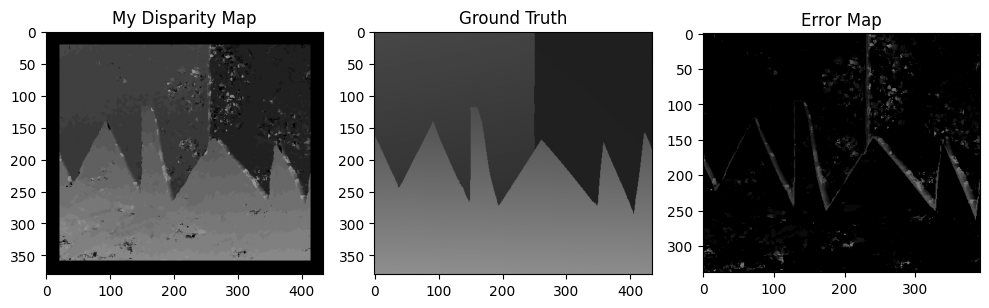

In [37]:
path_dataset = base_path + "sawtooth/"

for w in [17, 13, 9, 5]:
    r = (w-1) // 2
    compute_and_evaluate_disparity(path_dataset, window_radius=r, show_stereo_img=False)

Si nota chiaramente come al diminuire della dimensione della finestra, i bordi nella disparity map diventino sempre più precisi. Tuttavia, per i motivi osservati prima, si ha anche un incremento degli errori causati dalle regioni uniformi.

### Dimensionamento della finestra

Selecting the right window is important, because windows must be large enough to contain sufficient texture and yet small enough so that they do not straddle depth discontinuities.

Il problema del "Compromesso"
Finestre Grandi: Buone per le zone "piatte" (omogenee) perché hanno più informazioni e riducono l'ambiguità. Ma causano flattening foreground
Finestre Piccole: Buone per i bordi, perché non "mescolano" oggetti a distanze diverse. Ma sono più ambigue

to obtain accurate results not only at depth discontinuities but also in homogeneous regions, an appropriate support window should be selected for each pixel adaptively.


the support from a neighboring pixel is valid only when the neighboring pixel is from the same depth—it has the same disparity—with the pixel under consideration.
- impossibile saperlo dato che la disparità è proprio quello che stiamo cercando di calcolare

#### Errori dovuti ad occlusioni

## Piano di miglioramento